In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

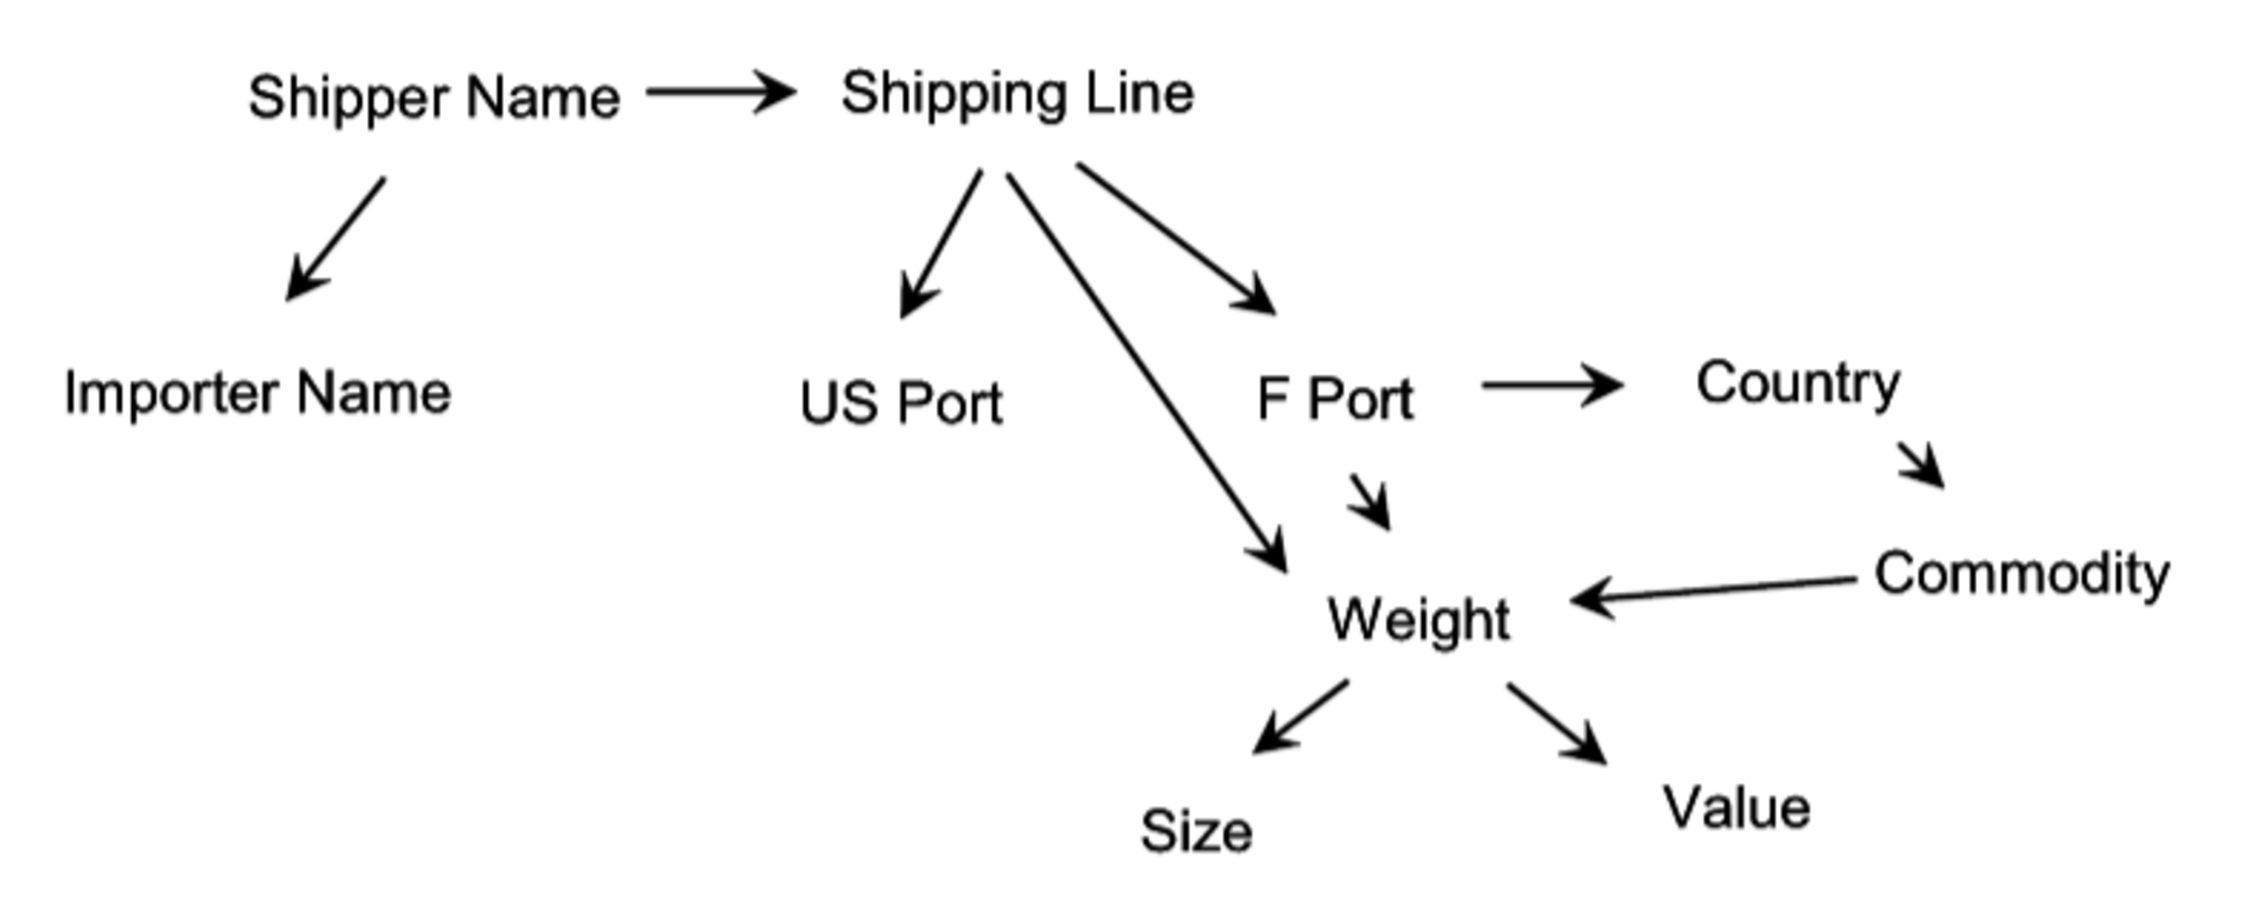

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)? Dependent

CI (Shipper Name, Value | Shipping Line)? Independent

CI (Foreign Port, Commodity | Country)? Independent

CI (Foreign Port, Commodity | County, Weight)? Dependent

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

**(Your answers here, including all calculations)**

a) P(Heavy|Seattle, Vancouver, ASCO) = P(Heavy, Seattle, Vancouver, ASCO) / P(Seattle, Vancouver, ASCO) 

= P(Heavy|ASCO, Vancouver) * P(Seattle|ASCO) * P(Vancouver|ASCO) * P(ASCO) / P(Seattle|ASCO) * P(Vancouver|ASCO) * P(ASCO)

= 0.15 * 1 * 1 * 0.3 / 1 * 1 * 0.3 = 0.15

b) P(Heavy|Vancouver, Seattle, CSCO) = P(Heavy, Vancouver, Seattle CSCO) / P(Vancouver, Seattle, CSCO)

= P(Heavy|Vancouver, CSCO) * P(Vancouver|CSCO) * P(Seattle|CSCO) * P(CSCO) / P(Vancouver|CSCO) * P(Seattle|CSCO) * P(CSCO)

= 0.2 * 0.6 * 0.8 * 0.7 / 0.6 * 0.8 * 0.7 = 0.2

c) P(Heavy|Yokohama, Los Angeles, CSCO) = P(Heavy|CSCO, Yokohama) * P(Yokohama|CSCO) * P(Los Angeles|CSCO) * P(CSCO) / P(Yokohama|CSCO) * P(Los Angeles|CSCO) * P(CSCO)

= 0.6 * 0.4 * 0.2 * 0.7 / 0.4 * 0.2 * 0.7 = 0.6

Therefore the package that is the most anomalous is a heavy package shipped from Vancouver to Seattle by ASCO.

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [3]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,0,1
2,1,1,0,1,1,1
3,1,0,0,1,1,1
4,2,0,1,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [4]:
# your answers here
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore

hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = hc.estimate()
print (best_model.edges())

[('B', 'A'), ('E', 'A'), ('D', 'A')]


In [5]:
from pgmpy.estimators import BayesianEstimator
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print ('CPD for {var}:'.format(var=cpd.variable))
    print cpd

CPD for A:
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| B    | B(0)                 | B(0)                  | B(0)                 | B(0)                 | B(1)                  | B(1)                 | B(1)                  | B(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| D    | D(0)                 | D(0)                  | D(1)                 | D(1)                 | D(0)                  | D(0)                 | D(1)                  | D(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| E    | 

In [6]:
print best_model.local_independencies(best_model.nodes())

(A _|_ C, F | B, E, D)
(C _|_ A, B, E, D, F)
(B _|_ C, E, D, F)
(E _|_ C, B, D, F)
(D _|_ C, B, E, F)
(F _|_ A, C, B, E, D)


In [7]:
from collections import defaultdict
from pgmpy.inference import VariableElimination

def temp_predict(model,data):
    missing_variables = list(set(model.nodes()) - set(data.columns))
    pred_values = defaultdict(list)
    model_inference = VariableElimination(model)
    for index, data_point in data.iterrows():
        states_dict = model_inference.map_query(variables=missing_variables, evidence=data_point.astype(int).to_dict())
        for k, v in states_dict.items():
            pred_values[k].append(v)
    return pd.DataFrame(pred_values, index=data.index)

test_x = test.loc[:,'B':'F']
predicted_test = temp_predict(best_model, test_x)
print "Out of sample accuracy for predicting A is:",(test.loc[:,'A']==predicted_test['A']).mean()

Out of sample accuracy for predicting A is: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

In [8]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [9]:
data3.shape

(119, 110)

In [10]:
#taking hours of the day only 
hours = data3.iloc[:,9:33]
hours.head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.073654,0.079320,0.076487,0.087819,0.082153,0.073654,0.039660,0.033994,0.014164,0.016997,...,0.019830,0.019830,0.025496,0.022663,0.022663,0.053824,0.033994,0.033994,0.042493,0.062323
1,0.055556,0.070370,0.033333,0.014815,0.025926,0.003704,0.007407,0.014815,0.018519,0.029630,...,0.055556,0.077778,0.048148,0.059259,0.044444,0.044444,0.077778,0.044444,0.074074,0.044444
2,0.040630,0.039580,0.033275,0.036778,0.018564,0.014011,0.012609,0.021366,0.025569,0.034676,...,0.055342,0.052189,0.059895,0.056392,0.062347,0.051839,0.053240,0.066550,0.055692,0.056042
3,0.034000,0.026000,0.018000,0.009000,0.010000,0.015000,0.020000,0.017000,0.033000,0.036000,...,0.045000,0.058000,0.073000,0.078000,0.068000,0.066000,0.059000,0.038000,0.051000,0.041000
4,0.009804,0.009804,0.029412,0.009804,0.009804,0.019608,0.039216,0.019608,0.000000,0.029412,...,0.029412,0.009804,0.107843,0.117647,0.058824,0.068627,0.078431,0.068627,0.049020,0.088235


In [11]:
hours.shape

(119, 24)

In [12]:
# normalizing along each sample
from sklearn import preprocessing
test=preprocessing.normalize(hours)
test.shape

(119, 24)

In [13]:
# instantiate a k-mean clustering algorithm with three clusters
from sklearn.cluster import KMeans
km = KMeans(random_state=234, n_clusters=3)
#fit to the data
res = km.fit(test)

### a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster. (5 pts)

In [14]:
data3_ = pd.concat((pd.Series(res.labels_, name='cluster'), pd.Series(data3.crime_type), hours), axis=1)
data3_.head(3)

,cluster,crime_type,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,ARSON: BY FIRE,0.073654,0.07932,0.076487,0.087819,0.082153,0.073654,0.039660,0.033994,...,0.019830,0.019830,0.025496,0.022663,0.022663,0.053824,0.033994,0.033994,0.042493,0.062323
1,1,ASSAULT: AGG PO HANDS NO/MIN INJURY,0.055556,0.07037,0.033333,0.014815,0.025926,0.003704,0.007407,0.014815,...,0.055556,0.077778,0.048148,0.059259,0.044444,0.044444,0.077778,0.044444,0.074074,0.044444
2,1,ASSAULT: AGGRAVATED: HANDGUN,0.040630,0.03958,0.033275,0.036778,0.018564,0.014011,0.012609,0.021366,...,0.055342,0.052189,0.059895,0.056392,0.062347,0.051839,0.053240,0.066550,0.055692,0.056042


In [15]:
means = data3_.groupby('cluster').mean()
means.head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.024234,0.014655,0.008345,0.003173,0.002277,0.000945,0.003173,0.007258,0.010805,0.022324,...,0.061356,0.045821,0.039698,0.043224,0.073860,0.110269,0.087821,0.076806,0.063549,0.037683
1,0.056713,0.045662,0.041718,0.034759,0.026793,0.018862,0.018951,0.021681,0.024401,0.029118,...,0.038134,0.043076,0.049008,0.051173,0.056337,0.058047,0.063397,0.060869,0.064575,0.056423
2,0.041765,0.017311,0.014343,0.012609,0.012031,0.011085,0.015704,0.026839,0.045605,0.075272,...,0.059247,0.064572,0.060360,0.056473,0.054671,0.046508,0.039663,0.030936,0.029776,0.025975


In [16]:
means.columns

Index([u'hour_0', u'hour_1', u'hour_2', u'hour_3', u'hour_4', u'hour_5',
       u'hour_6', u'hour_7', u'hour_8', u'hour_9', u'hour_10', u'hour_11',
       u'hour_12', u'hour_13', u'hour_14', u'hour_15', u'hour_16', u'hour_17',
       u'hour_18', u'hour_19', u'hour_20', u'hour_21', u'hour_22', u'hour_23'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

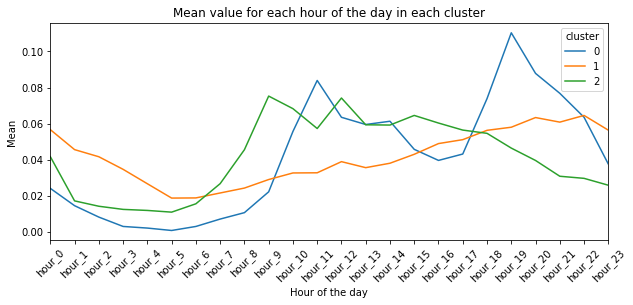

In [17]:
plt.figure()
means.T.plot(figsize=(10,4), x_compat=True, rot=45)
plt.xticks(np.arange(24), means.columns)
plt.title('Mean value for each hour of the day in each cluster')
plt.xlabel('Hour of the day')
plt.ylabel('Mean')
plt.show()

### b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

**cluster 1 is the least volatile, however it represents the type of crimes that are happening almost in every hour of the day. on the other hand we notice that clusters 0 and 2 show crimes that go down significantly during the early hours of the day. 
we can't but notice the spike in cluster zero at hour 19. 10% of the crimes in cluster zero happen at hour 19 (8 to 9 pm). Both clusters 0 and 2 have a high proportion (6% to 8%) of their crimes happening between hours 9 and 14 (9am to 3pm)**

### c) Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)

In [18]:
pd.set_option('display.max_colwidth', -1)
crime = data3_.groupby('cluster')['crime_type'].unique().to_frame(name='crime').T
for col in crime.columns:
    print 'crimes in cluster {} are:\n {}'.format(col, list(crime[col]))
    print 

crimes in cluster 0 are:
 [array(['DECEPTIVE PRACTICE: COUNTERFEITING DOCUMENT',
       'GAMBLING: GAME/DICE',
       'INTERFERENCE WITH PUBLIC OFFICER: OBSTRUCTING IDENTIFICATION',
       'NARCOTICS: MANU/DEL:CANNABIS 10GM OR LESS',
       'NARCOTICS: MANU/DEL:CANNABIS OVER 10 GMS',
       'NARCOTICS: MANU/DELIVER: HEROIN (WHITE)',
       'NARCOTICS: MANU/DELIVER:CRACK',
       'NARCOTICS: POSS: CANNABIS 30GMS OR LESS',
       'NARCOTICS: POSS: CANNABIS MORE THAN 30GMS',
       'NARCOTICS: POSS: CRACK', 'NARCOTICS: POSS: HEROIN(WHITE)',
       'NARCOTICS: POSS: PCP', 'NARCOTICS: POSS: SYNTHETIC DRUGS',
       'NARCOTICS: POSSESSION OF DRUG EQUIPMENT',
       'NARCOTICS: SOLICIT NARCOTICS ON PUBLICWAY',
       'OTHER OFFENSE: GUN OFFENDER: ANNUAL REGISTRATION',
       'OTHER OFFENSE: GUN OFFENDER: DUTY TO REGISTER',
       'OTHER OFFENSE: LICENSE VIOLATION',
       'OTHER OFFENSE: PAROLE VIOLATION',
       'PUBLIC PEACE VIOLATION: RECKLESS CONDUCT'], dtype=object)]

crimes in cluster 1

**we notice the main crime type in each cluster is as follows:  
        cluster 0: Narcotics  
        cluster 1: Unlawful offensive physical contact such as battery, assault as well as theft and robbery  
        cluster 2: Deceptive Practice and other crimes**

### d) Do the three clusters have different day-of-week trends? Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences. (5 pts)

In [19]:
days = data3.iloc[:,2:9]
days.head()

,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
0,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972
1,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185
2,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776
3,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000
4,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275


In [20]:
data3_1 = pd.concat((pd.Series(res.labels_, name='cluster'), pd.Series(data3.crime_type), days), axis=1)
data3_1.head(3)

,cluster,crime_type,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
0,1,ARSON: BY FIRE,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972
1,1,ASSAULT: AGG PO HANDS NO/MIN INJURY,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185
2,1,ASSAULT: AGGRAVATED: HANDGUN,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776


In [21]:
data3_1.shape

(119, 9)

In [22]:
means_1 = data3_1.groupby('cluster').mean()
means_1.head()

,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
cluster,,,,,,,
0,0.117822,0.149307,0.156998,0.146312,0.142985,0.156099,0.130477
1,0.152098,0.133113,0.137037,0.134740,0.135537,0.150625,0.156851
2,0.113896,0.152089,0.151522,0.148864,0.150943,0.154897,0.127789


<Figure size 432x288 with 0 Axes>

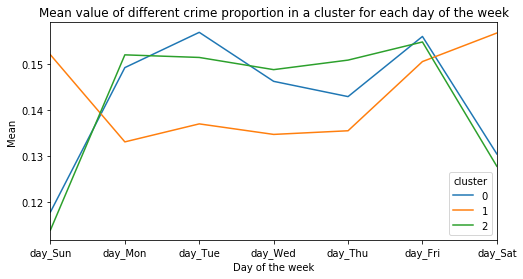

In [23]:
plt.figure()
means_1.T.plot(figsize=(8,4), x_compat=True)
plt.xticks(np.arange(7), means_1.columns)
plt.title('Mean value of different crime proportion in a cluster for each day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Mean')
plt.show()

**again we notice the trends in cluster 0 and 2 to be more consistent with each other if compared with trend 1. the consistency is very clear when looking at the ditribution along the days instead our hours. while crimes in cluster 0 and 2 peak during weekdays and are less on the weekends, we see crimes in cluster 1 following an opposite trend by peaking on weekends.**

### e) Do the three clusters affect different types of communities/neighborhoods? To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster. You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.). You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

In [24]:
communities = data3.loc[:, 'community_area_1': 'community_area_77']
communities.head()

,community_area_1,community_area_2,community_area_3,community_area_4,community_area_5,community_area_6,community_area_7,community_area_8,community_area_9,community_area_10,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,0.005666,0.008499,0.002833,0.000000,0.000000,0.005666,0.011331,0.002833,0.000,0.000000,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,0.014815,0.011111,0.014815,0.003704,0.003704,0.018519,0.003704,0.011111,0.000,0.007407,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,0.009107,0.009457,0.006655,0.003152,0.002102,0.003152,0.001751,0.010158,0.000,0.002102,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,0.014000,0.011000,0.014000,0.003000,0.006000,0.012000,0.004000,0.021000,0.001,0.002000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,0.000000,0.009804,0.000000,0.009804,0.009804,0.019608,0.000000,0.000000,0.000,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [25]:
data3_2 = pd.concat((pd.Series(res.labels_, name='cluster'), pd.Series(data3.crime_type), communities), axis=1)
data3_2.head(3)

,cluster,crime_type,community_area_1,community_area_2,community_area_3,community_area_4,community_area_5,community_area_6,community_area_7,community_area_8,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,1,ARSON: BY FIRE,0.005666,0.008499,0.002833,0.000000,0.000000,0.005666,0.011331,0.002833,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,1,ASSAULT: AGG PO HANDS NO/MIN INJURY,0.014815,0.011111,0.014815,0.003704,0.003704,0.018519,0.003704,0.011111,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,1,ASSAULT: AGGRAVATED: HANDGUN,0.009107,0.009457,0.006655,0.003152,0.002102,0.003152,0.001751,0.010158,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152


In [26]:
data3_1.shape

(119, 9)

In [27]:
means_2 = data3_2.groupby('cluster').mean()
means_2.head()

,community_area_1,community_area_2,community_area_3,community_area_4,community_area_5,community_area_6,community_area_7,community_area_8,community_area_9,community_area_10,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.007531,0.006089,0.007206,0.002148,0.001260,0.006613,0.001789,0.014841,0.000432,0.001453,...,0.040188,0.028929,0.002517,0.032770,0.000711,0.009657,0.000638,0.007942,0.001007,0.001367
1,0.013667,0.012769,0.013013,0.007196,0.004290,0.018644,0.010134,0.025921,0.000605,0.003149,...,0.027023,0.027825,0.009378,0.028577,0.002725,0.010567,0.001580,0.006601,0.004008,0.006891
2,0.014697,0.012971,0.015908,0.009332,0.005756,0.025262,0.014600,0.044862,0.001657,0.006396,...,0.019941,0.024469,0.009294,0.026532,0.004455,0.012293,0.003177,0.008832,0.016872,0.010893


<Figure size 432x288 with 0 Axes>

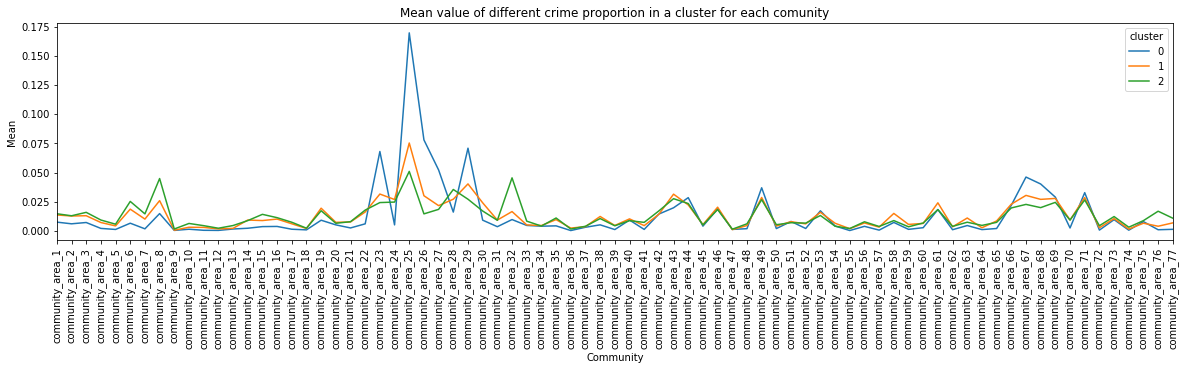

In [28]:
plt.figure()
means_2.T.plot(figsize=(20,4), x_compat=True, rot=90)
plt.xticks(np.arange(77), means_2.columns)
plt.title('Mean value of different crime proportion in a cluster for each comunity')
plt.xlabel('Community')
plt.ylabel('Mean')
plt.show()

**we notice that the three clusters of crimes follow almost the same trend in all communities except for a peak in the trend of cluster 0 that is not observed for the other two clusters. we notice a significant peak in the crimes of cluster 0 in communities 23 to 30. if we consult the Chicago Community Areas map found her https://en.wikipedia.org/wiki/Community_areas_in_Chicago we see that these communities fall in the west side. according to this source some neighborhoods in the west side, particularly Garfield Park and Lawndale, have had long-term socio-economic problems. the latter could explain why cirmes in cluster 1 (mainly narcotics) surge in these communities.**

In [29]:
#socio economic data for communities in chicago
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


In [30]:
west_side = data4[data4['Community Area Number'].isin(range(23,32))]
west_side.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
22,23,Humboldt park,1151216.159,1906926.141,14.8,33.9,17.3,35.4,38.0,13781,15.839488,7522
23,24,West Town,1163041.478,1907678.393,2.3,14.7,6.6,12.9,21.7,43198,8.734616,7754
24,25,Austin,1140839.462,1903174.321,6.3,28.6,22.6,24.4,37.9,15957,14.188517,15719
25,26,West Garfield Park,1148754.852,1898785.758,9.4,41.7,25.8,24.5,43.6,10934,27.504936,5340
26,27,East Garfield Park,1155086.641,1898653.301,8.2,42.4,19.6,21.3,43.2,12961,19.899589,4727


In [31]:
print 'mean percent of crowded housing in west side across communities is', west_side['PERCENT OF HOUSING CROWDED'].mean()
print 'while the mean percent of crowded housing in chicago is ', data4['PERCENT OF HOUSING CROWDED'].mean()
print
print 'mean percent of households below poverty in west side across communities is', west_side['PERCENT HOUSEHOLDS BELOW POVERTY'].mean()
print 'while the mean percent of households below poverty in chicago is ', data4['PERCENT HOUSEHOLDS BELOW POVERTY'].mean()
print
print 'mean percent of aged 16+ and unemployed in west side across communities is', west_side['PERCENT AGED 16+ UNEMPLOYED'].mean()
print 'while the mean percent of aged 16+ and unemployed in chicago is ', data4['PERCENT AGED 16+ UNEMPLOYED'].mean()

mean percent of crowded housing in west side across communities is 8.55555555556
while the mean percent of crowded housing in chicago is  4.92337662338

mean percent of households below poverty in west side across communities is 31.2777777778
while the mean percent of households below poverty in chicago is  21.7662337662

mean percent of aged 16+ and unemployed in west side across communities is 17.2666666667
while the mean percent of aged 16+ and unemployed in chicago is  15.3727272727


**further exploring the socio economic conditions of communities in the west side of Chicago shows that the average percent of crowded housing, households below poverty and unemployed people aged 16+ is always higher for these communities when compared with the average across all the communities in Chicago.**

### f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

In [32]:
data3_2 = pd.concat((pd.Series(res.labels_, name='cluster'), pd.Series(data3.Category)), axis=1)
data3_2.head(3)

,cluster,Category
0,1,P1P
1,1,P2
2,1,P1V


In [33]:
category = data3_2.groupby('cluster')['Category'].unique().to_frame(name='category').T
for col in category.columns:
    print 'categories in cluster {} are:\n {}'.format(col, category[col])
    print 

categories in cluster 0 are:
 category    [P2]
Name: 0, dtype: object

categories in cluster 1 are:
 category    [P1P, P2, P1V]
Name: 1, dtype: object

categories in cluster 2 are:
 category    [P1V, P2, P1P]
Name: 2, dtype: object



**only cluster 0 has the same ctaegory of crimes all over. cluster 0 only include crimes that are categorized by the FBI as serious violent crimes. on the other hand the other two clusters include crimes of the three different categories present in the data.**

### g) For part g, you will use the same dataset to compare the clusters produced by several different methods. But this time you should cluster using only the day-of-week (not hour-of-day) attributes (day_Sun..day_Sat). Please perform four different clusterings using:  
(i) k-means,  
(ii) Gaussian mixture models,  
(iii) Bottom-up hierarchical clustering with "single link" distance metric, and  
(iv) Bottom-up hierarchical clustering with "complete link" distance metric.  
In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  
For each clustering, report the number of clusters formed and the number of elements in each cluster.  
You should also identify any notable similarities or differences between the clusterings. (20 pts)

In [34]:
days.head()

,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
0,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972
1,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185
2,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776
3,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000
4,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275


In [35]:
# normalizing along each sample
test=preprocessing.normalize(days)
test.shape

(119, 7)

**(i) k-means**

2 3.3135475366038163
3 2.7578255873575905
4 2.3947948836344835
5 2.1167918097525265
6 1.8957204524804974
7 1.7899457920388142
8 1.705629480671604
9 1.5778206530645134


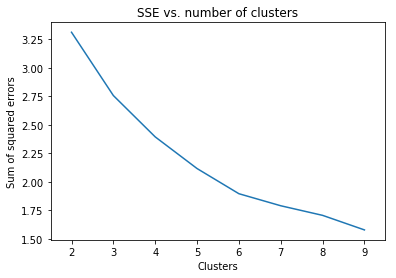

In [36]:
# to determine the right number of clusters look for an elbow in the within-cluster SSE 
SSE = []
for i in range(2,10):
    km = KMeans(n_clusters = i)
    res=km.fit(test)
    SSE.append(res.inertia_)
    print i, res.inertia_

plt.gca()
plt.plot(range(2,10),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,9.5)
plt.xticks(np.arange(2,10))
plt.show()

In [37]:
#we notice an elbow around 4,5,6 clusters
# calculate silhouette coefficient to corroborate our results
# larger silhouette score (closer to 1) = better clustering

from sklearn.metrics import silhouette_score

score = []
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    cluster_labels= KMeans(random_state=234, n_clusters=n_clusters).fit(test).labels_   
    silhouette_avg = silhouette_score(test, cluster_labels)
    score.append(silhouette_avg)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.239351092304
For n_clusters = 3, the average silhouette_score is : 0.217590477557
For n_clusters = 4, the average silhouette_score is : 0.213995301495
For n_clusters = 5, the average silhouette_score is : 0.240896045323
For n_clusters = 6, the average silhouette_score is : 0.166150622744
For n_clusters = 7, the average silhouette_score is : 0.173954309346
For n_clusters = 8, the average silhouette_score is : 0.180470445729
For n_clusters = 9, the average silhouette_score is : 0.160420320209


In [38]:
# instantiate a k-mean clustering algorithm with five clusters 
# based on the graph above the first elbow occurs at clusters=5 and clusters=5 have the highest silhouette score 0.2408
km = KMeans(random_state=234, n_clusters=5)
#fit to the data
res = km.fit(test)

print 'Clustering using KMeans:'
print 'number of clusters formed = ',res.n_clusters
print 'number of elements in each cluster', {i: len(np.where(res.labels_ == i)[0]) for i in range(res.n_clusters)}

Clustering using KMeans:
number of clusters formed =  5
number of elements in each cluster {0: 64, 1: 2, 2: 15, 3: 4, 4: 34}


**(ii) Gaussian mixture models**

Reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach. The optimal number of clusters is the value that minimizes the AIC or BIC

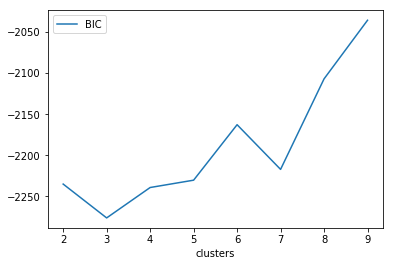

In [39]:
# The optimal number of clusters is the value that minimizes the AIC or BIC
from sklearn.mixture import GaussianMixture
n_components = np.arange(2, 10)
models = [GaussianMixture(n, random_state=100).fit(test)
          for n in n_components]

plt.plot(n_components, [m.bic(test) for m in models], label='BIC')
# plt.plot(n_components, [m.aic(test) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('clusters')
plt.xticks(np.arange(2,10))
plt.show()

In [40]:
# based on the least BIC score in the above graph we will instantiate
# a gaussian mixture model with 3 clusters
gmm = GaussianMixture(n_components=3,random_state=100)
res = gmm.fit(test)
print 'Clustering using Gaussian mixture models:'
print 'number of clusters formed = ',res.n_components
print 'number of elements in each cluster', {i: len(np.where(res.predict(test) == i)[0]) for i in range(res.n_components)}

Clustering using Gaussian mixture models:
number of clusters formed =  3
number of elements in each cluster {0: 25, 1: 78, 2: 16}


**(iii) Bottom-up hierarchical clustering with "single link" distance metric**

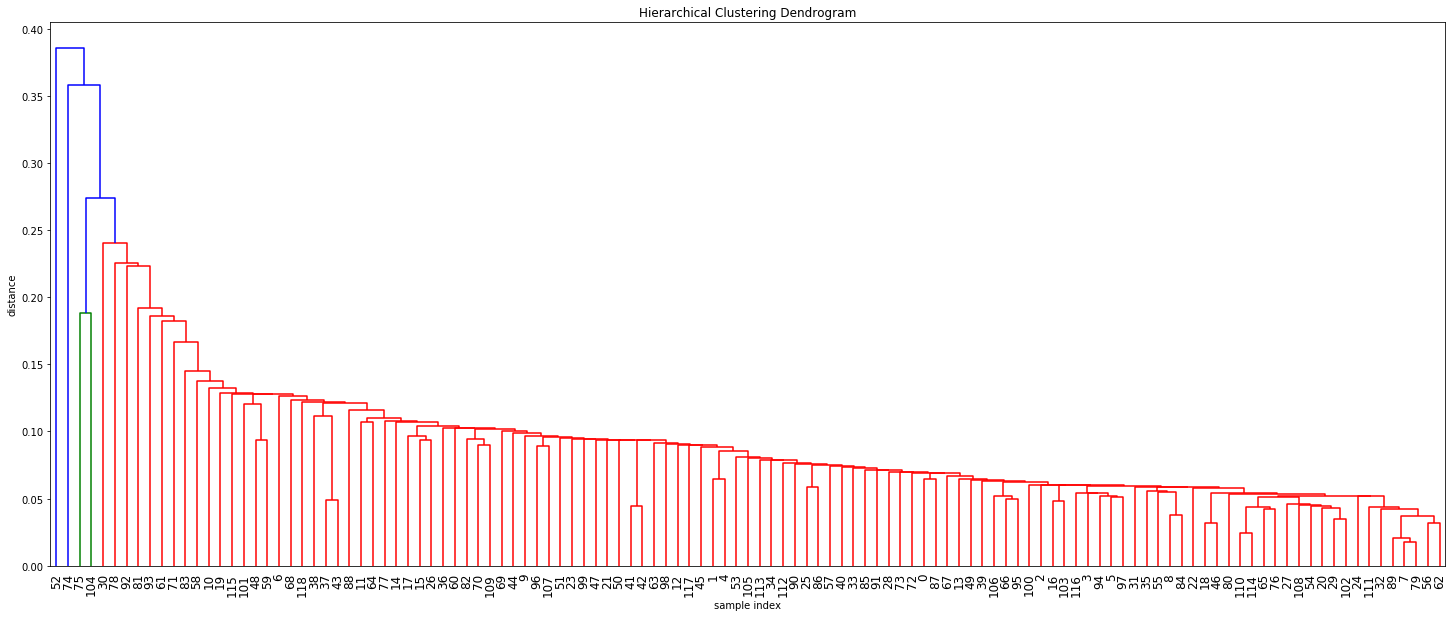

In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

Z = linkage(test, 'single')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
)
plt.show()

In [42]:
# larger silhouette score (closer to 1) = better clustering
score = []
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Z, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(test, cluster_labels)
    score.append(silhouette_avg)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.593378528413
For n_clusters = 3, the average silhouette_score is : 0.52442879688
For n_clusters = 4, the average silhouette_score is : 0.387653789354
For n_clusters = 5, the average silhouette_score is : 0.367539507864
For n_clusters = 6, the average silhouette_score is : 0.320284634766
For n_clusters = 7, the average silhouette_score is : 0.322447909226
For n_clusters = 8, the average silhouette_score is : 0.303217734008
For n_clusters = 9, the average silhouette_score is : 0.290901715109


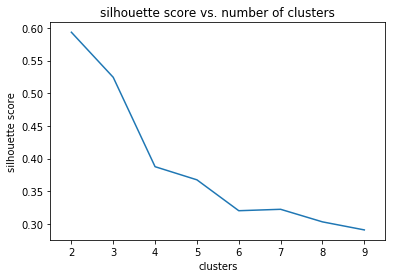

In [43]:
plt.gca()
plt.plot(range(2,10),score)
plt.xlabel("clusters")
plt.ylabel("silhouette score")
plt.title("silhouette score vs. number of clusters")
plt.xlim(1.5,9.5)
plt.xticks(np.arange(2,10))
plt.show()

In [44]:
# form clusters
clusters = fcluster(Z, 2, criterion='maxclust')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [45]:
c = pd.Series(clusters).value_counts().sort_index()
c

1    118
2    1  
dtype: int64

In [46]:
print 'Bottom-up hierarchical clustering with "single link" distance metric'
print 'number of clusters formed = ', len(c)
print 'number of elements in each cluster', {i: sum(clusters == i) for i in range(1,len(c)+1)}

Bottom-up hierarchical clustering with "single link" distance metric
number of clusters formed =  2
number of elements in each cluster {1: 118, 2: 1}


**(iv) Bottom-up hierarchical clustering with "complete link" distance metric**

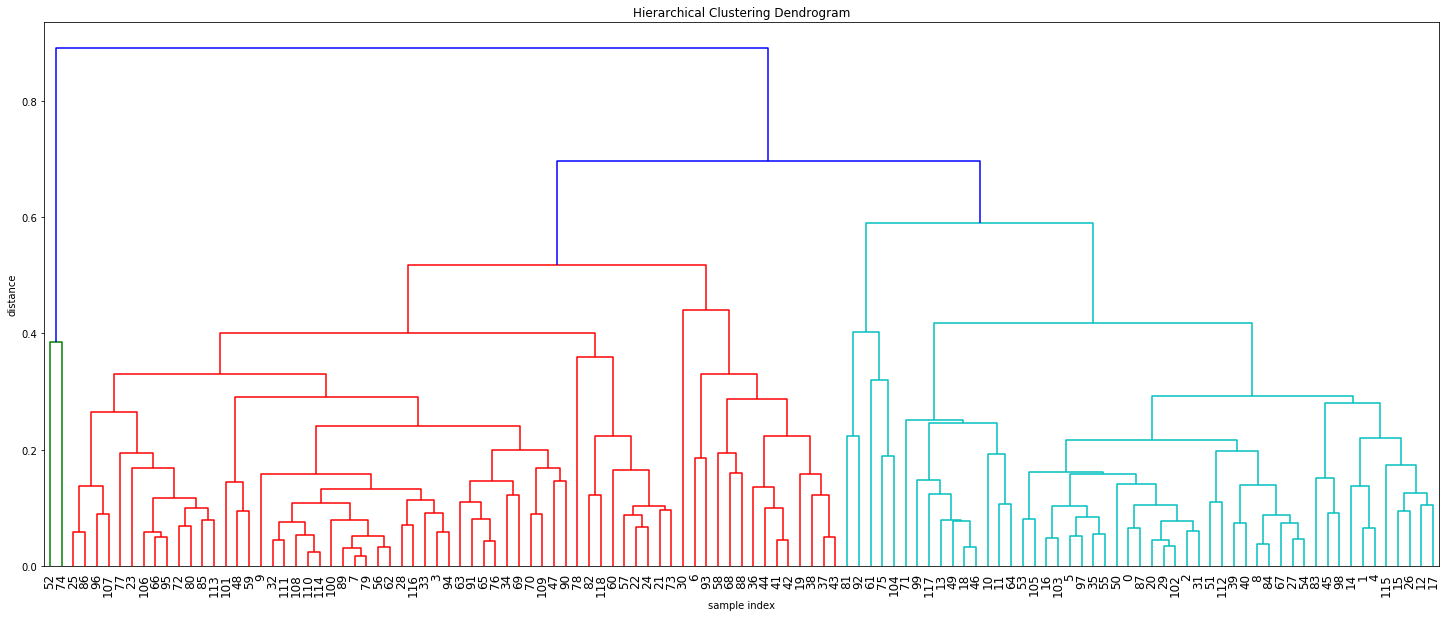

In [47]:
Z = linkage(test, 'complete')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.57127250569
For n_clusters = 3, the average silhouette_score is : 0.212229263232
For n_clusters = 4, the average silhouette_score is : 0.223120410038
For n_clusters = 5, the average silhouette_score is : 0.21638382182
For n_clusters = 6, the average silhouette_score is : 0.217157924332
For n_clusters = 7, the average silhouette_score is : 0.156676820764
For n_clusters = 8, the average silhouette_score is : 0.163321048269
For n_clusters = 9, the average silhouette_score is : 0.130069555988


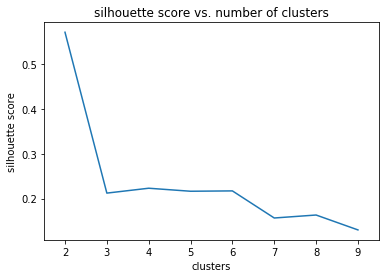

In [48]:
# larger silhouette score (closer to 1) = better clustering
score = []
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    cluster_labels=fcluster(linkage(test, 'complete'), n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(test, cluster_labels)
    score.append(silhouette_avg)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

plt.gca()
plt.plot(range(2,10),score)
plt.xlabel("clusters")
plt.ylabel("silhouette score")
plt.title("silhouette score vs. number of clusters")
plt.xlim(1.5,9.5)
plt.xticks(np.arange(2,10))
plt.show()

In [49]:
clusters = fcluster(linkage(test, 'complete'), t=2, criterion='maxclust')
clusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [50]:
c = pd.Series(clusters).value_counts().sort_index()
c

1    2  
2    117
dtype: int64

In [51]:
print 'Bottom-up hierarchical clustering with "complete link" distance metric'
print 'number of clusters formed = ', len(c)
print 'number of elements in each cluster', {i: sum(clusters == i) for i in range(1,len(c)+1)}

Bottom-up hierarchical clustering with "complete link" distance metric
number of clusters formed =  2
number of elements in each cluster {1: 2, 2: 117}


**It is noticeable that k-means and gaussian mixture models (group one) produce similar clustering results. on the other hand the different methods of heirarchal clustering (group2) produce results that are close to each other. while group one produced 3 & 5 clusters repectively for each method, group two performed best at two clusters (as per the silhoutte coeffient). models in group one were able to capture the different trends in the data much better than group 2. this is observed from the number of samples that were assigned to each cluster. we notice that the samples were distributed along the clusters almost in the same manner along the two models in group 1 while almost all of them were assigned to the same cluster in group2.**